In [1]:
import pandas as pd
import os.path

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

import altair as alt

# Show an image where the interactive plot is not supported such as on gradescope
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server') 

DataTransformerRegistry.enable('data_server')

# Project: (TBD) Olympics Medals and Age Analysis
## Exploratory Data Analysis

Here is the URL of our data source:

https://github.com/rfordatascience/tidytuesday/tree/master/data/2021/2021-07-27

Direct download links to individual CSV files:

The only file we need for our purpose:

https://github.com/rfordatascience/tidytuesday/raw/master/data/2021/2021-07-27/olympics.csv 

Other files:

https://github.com/rfordatascience/tidytuesday/raw/master/data/2021/2021-07-27/athlete_events.csv
https://github.com/rfordatascience/tidytuesday/raw/master/data/2021/2021-07-27/noc_regions.csv
https://github.com/rfordatascience/tidytuesday/raw/master/data/2021/2021-07-27/regions.csv

Based on the source page, we understand that we really need the `olympics.csv` file which is the cleaned version of the file `athlete.csv`.  The other 2 files only contains redundant information as far as our analytic objective is concerned.  So we are going to do EDA on the `olympics.csv` file here.

The data dictionary is available here:

https://github.com/rfordatascience/tidytuesday/tree/master/data/2021/2021-07-27#olympicscsv

And I am including it for your convenience:

|variable |class     |description |
|:--------|:---------|:-----------|
|id       |double    | Athlete ID |
|name     |character | Athlete Name |
|sex      |character | Athlete Sex |
|age      |double    | Athlete Age |
|height   |double    | Athlete Height in cm|
|weight   |double    | Athlete weight in kg |
|team     |character | Country/Team competing for|
|noc      |character | noc region |
|games    |character | Olympic games name |
|year     |double    | Year of olympics |
|season   |character | Season either winter or summer |
|city     |character | City of Olympic host |
|sport    |character | Sport |
|event    |character | Specific event |
|medal    |character | Medal (Gold, Silver, Bronze or NA) |

Let's load the data and find out more.

In [2]:
local_path = "../data/raw/olympics.csv"

## Read local file if already exists, otherwise read from URL.
try:
    olympics_raw = pd.read_csv(local_path)
except:
    print("Please ensure that the following file is available:\n", local_path)
olympics_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      271116 non-null  int64  
 1   name    271116 non-null  object 
 2   sex     271116 non-null  object 
 3   age     261642 non-null  float64
 4   height  210945 non-null  float64
 5   weight  208241 non-null  float64
 6   team    271116 non-null  object 
 7   noc     271116 non-null  object 
 8   games   271116 non-null  object 
 9   year    271116 non-null  int64  
 10  season  271116 non-null  object 
 11  city    271116 non-null  object 
 12  sport   271116 non-null  object 
 13  event   271116 non-null  object 
 14  medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [3]:
olympics_raw.describe()

,id,age,height,weight,year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [4]:
# Let's take a sample of some rows.

olympics_raw.sample(5)

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
60673,31070,Geronimo Dyogi,M,23.0,167.0,70.0,Philippines,PHI,1972 Summer,1972,Summer,Munich,Judo,Judo Men's Half-Middleweight,NaN
231273,116040,Nadia Styger (-Hrlimann),F,31.0,171.0,70.0,Switzerland,SUI,2010 Winter,2010,Winter,Vancouver,Alpine Skiing,Alpine Skiing Women's Super G,NaN
97802,49491,"Frederick William ""Fred"" Holmes",M,33.0,NaN,NaN,Great Britain,GBR,1920 Summer,1920,Summer,Antwerpen,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
125284,63220,Oksana Kotova,F,19.0,NaN,NaN,Kazakhstan,KAZ,1994 Winter,1994,Winter,Lillehammer,Cross Country Skiing,Cross Country Skiing Women's 5/10 kilometres P...,NaN
70077,35697,Leon Victor Flack,M,21.0,188.0,76.0,Great Britain,GBR,2002 Winter,2002,Winter,Salt Lake City,Short Track Speed Skating,"Short Track Speed Skating Men's 1,000 metres",NaN


### Points to note:

1. There are 271116 rows of data and 14 columns.  
2. The each observation as an athlete-event pair.  In other words, an athlete could participate in more than 1 event in the same Olympic game.
3. Missing values:
3.1. Most columns do not have missing values.  

3.2. `Age`, `height` and `weight` have some missing values. 

3.3. Even though `medal` appears to have a lot of missing values, but they are really not because the meaning of NaN (`NA` as in the CSV file) should mean that the athletes did not get any medal.  I think that is natural because there are very small number of medals per event!  For this EDA exercise, we may just treat `NaN` as a category together with `Gold`, `Silver` and `Bronze`
4. `id` is the unique identifier for an athlete and `noc` is the unique identifier for a NOC which mostly often represents a country except `IOA` (standing for "Individual Olympic Athlete") which is the representation for athletes without an NOC and similiarly `ROT` (standing for "Refugee Olympic Team").  

Since we focus on `age`, we are going to remove the observations where `age` is missing.

In [5]:
olympics_df = olympics_raw[olympics_raw['age'].notna()]

Let's explore how age correlates with other numeric features

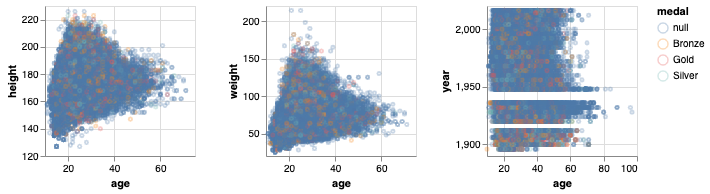

In [6]:
numeric_cols_names = ['height', 
                      'weight',
                      'year']

numeric_cols_plot = alt.Chart(olympics_df).mark_point(opacity=0.3, size=10).encode(
     alt.X('age', type='quantitative', scale=alt.Scale(zero=False)),
     alt.Y(alt.repeat('column'), type='quantitative', scale=alt.Scale(zero=False)),
     color='medal:N'
).properties(
    width=150,
    height=150
).repeat(
    column=numeric_cols_names
)

numeric_cols_plot

It seems hard to visualize when the class imbalance is with `medal` when not having a medal is the majority.  Now we try again with the data only with medals and look at the data again.

In [7]:
olympics_medals_df = olympics_df[olympics_df['medal'].notna()]
olympics_medals_df.shape

(39051, 15)

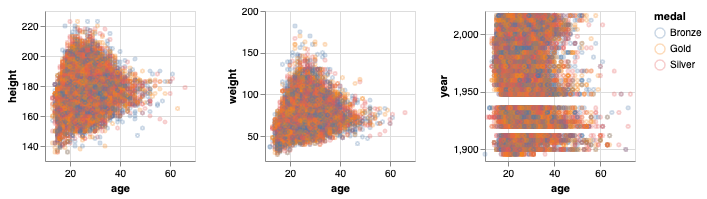

In [8]:
numeric_cols_names = ['height', 
                      'weight',
                      'year']

numeric_cols_plot = alt.Chart(olympics_medals_df).mark_point(opacity=0.3, size=10).encode(
     alt.X('age', type='quantitative', scale=alt.Scale(zero=False)),
     alt.Y(alt.repeat('column'), type='quantitative', scale=alt.Scale(zero=False)),
     color='medal:N'
).properties(
    width=150,
    height=150
).repeat(
    column=numeric_cols_names
)

numeric_cols_plot

Some high-level insights:

1. There is some apparently correlation of between height and age and between weight and age for those who got medals; and
2. The maximum age of athletes getting medals seemed to shrink between 1960s and 1980s, and it seemed to increase again till now.

Perhaps we should simply just look at the relationship between age and medals...

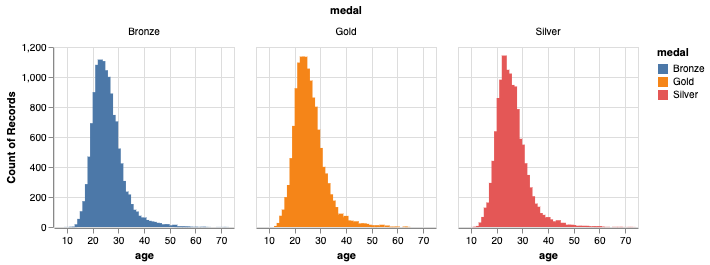

In [9]:
age_medals_hist = alt.Chart(olympics_medals_df).mark_bar().encode(
    alt.X('age:Q', scale=alt.Scale(zero=False)),
    alt.Y('count()'),
    color=('medal'),
    tooltip=['age', 'medal', 'count()']
).properties(
    width=180,
    height=180
).facet(
    facet='medal:N',
    columns=3
)
age_medals_hist

All the modes for `Gold`, `Silver` and `Bronze` are age = 23.

Now let's also explore the categorical features.

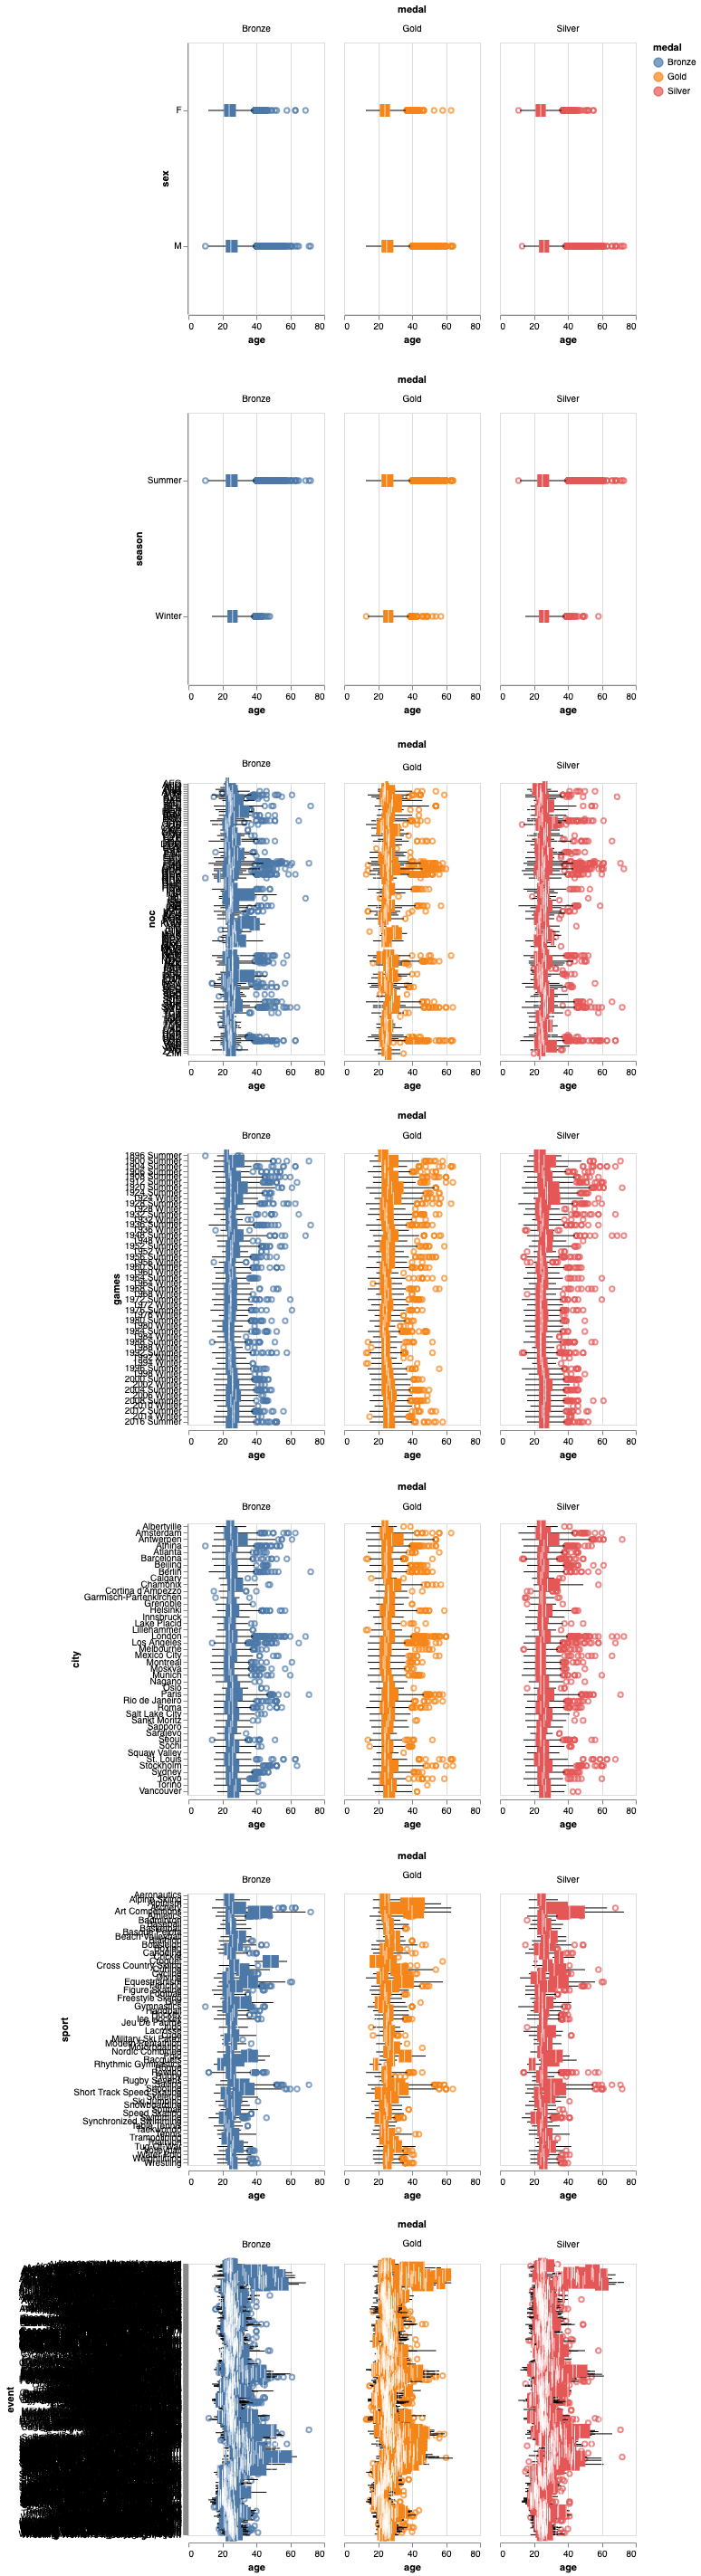

In [10]:
cat_cols = ['sex',
            'season',
            'noc',
            'games',
            'city',
            'sport',
            'event']

cat_plots = alt.Chart(olympics_medals_df).mark_boxplot().encode(
    x=alt.X('age', type='quantitative'),
    y=alt.Y(alt.repeat('row'), type='nominal'),
    color='medal:N',
    tooltip=['age']
).properties(
    height=300,
    width=150
).facet(
    facet='medal:N',
    columns=3
).repeat(
    row=cat_cols
)

cat_plots

## Comments by categorical features:

1. `Sex` - The male medalists seem to have a higher mean age than female counterparts but not by a lot.  The age distribution of male medalists is also more right-skewed compared with female medalists;
2. `season` - The age spread is larger for `summer` over `winter` and the distribution of `summer` is more right-skewed than `winter`.

I know that the labels are not very readable, but for the other categorical features, namely `noc`, `games`, `city`, `sport` and `event`, and for the purpose of this EDA, it is just to show that:
1. `age` varies greatly across those categorical features.  
2. The 3 medals apparently to distribute very similarly with all those features.